# Title: Analysis of tweets by V̵̢̨͖̋͆̈́̽̿̕ḯ̶̡̜͔̩̰̠̬̰̖͉̱͎̼̌͂c̷͓͓̤̩̺̀̓ỏ̸̧͓̙͎͖͇͍̎͂̏́̀̆͋̎̕͝͝ ̵̫̪͍̟͖͓̹̟̋̾̊̾͛̄̈̿̿̇̿͛̔͐̚Ș̶̳͍̒́̋̊o̴̺͖̝͎̯̬̥̓̂̔̓̅̇͜͠ẗ̵͉̗̜̎̽̎̂̓̿̕͜t̷̡̲̞͈͖̋ǫ̵͈̫̫͘͜ ̷̦̱̥̰͚̜̼͎͎̿̎̒̏̔̏͐̆͂͂͋̕̚̚͝a̶̮̜͑̀͂̄̏̌̏́̎͛͋͗͝͝n̶̡̉͆d̵͔͉͔͍̜̠͍̪̖̖͚̼̋̕ͅ ̵̢̪̤̲͎̘͈̳̪͚̜͍̝̝̟͋͑͂͌̈́͗̈͐̔͘I̶̢̮̜̩̼̥͕̺̰͖̗̩͍͆̄́̚s̵̢̨͍͕̙̱͈̲͈̠̭̦͖̟̎́̉k̶͎̯̲͔͇͌͛́̕ͅơ̸̥͈̺̭͙̘̘͔̻̒̾̎̔͛̒͐̚͘̕͜ ̸̧͍̩̭̫͙̦̘̤̖̹̺̯͌̓͒̌̎̒̋́̾̅͜M̵͙̖̘̦̟̩̘̭̋̊̃̍̏̿ͅö̸̟̮̮̩͕́̾́̈́̃͜͜r̶̨̡̛̘̬̖̥͕̞͎͙͎̊̇͗͛͊͆͜e̵͓̹͍̭̪͔͊͜͠ṉ̸̡̨̛͕̦̲̈́̅̔̅̆́̅̋͝o̷̢̳̝̞̝̘͍͉̮̚


We train a classifier to distinguish between the tweets of Vico Sotto and Isko Moreno and find the most probable and least probable tweets of each person.

- Based on the article https://towardsdatascience.com/twitter-api-and-nlp-7a386758eb31

# Setup

In [1]:
!pip install -q tweepy pandas numpy sklearn nltk gensim ipython-secrets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import tweepy
import sys

import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec

from ipython_secrets import *
import warnings
warnings.filterwarnings("ignore")

nltk.download("stopwords")

SEED = 42

[nltk_data] Downloading package stopwords to /Users/TL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Collection

Collect all tweets posted by Vico Sotto and Isko Moreno.

In [3]:
#https://docs.tweepy.org/en/latest/getting_started.html

consumer_key = get_secret('CONSUMER_KEY')
consumer_secret = get_secret('CONSUMER_SECRET')
access_token = get_secret('ACCESS_TOKEN')
access_token_secret = get_secret('ACCESS_TOKEN_SECRET')

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [4]:
#https://fairyonice.github.io/extract-someones-tweet-using-tweepy.html
vico_id = 'vicosotto'
isko_id = 'iskomoreno'

def get_tweets_of(id):
  all_tweets = []
  oldest_id = sys.maxsize
  while True:
    #https://stackoverflow.com/questions/7604966/maximum-and-minimum-values-for-ints
    tweets =  api.user_timeline(screen_name=id, 
                            # 200 is the maximum allowed count
                            count=200,
                            include_rts = False,
                            max_id = oldest_id - 1,
                            # Necessary to keep full_text 
                            # otherwise only the first 140 words are extracted
                            tweet_mode = 'extended'
                            )
    if len(tweets) == 0:
        break
    oldest_id = tweets[-1].id
    all_tweets.extend(tweets)
    print('N of tweets of {} downloaded: {}'.format(id, len(all_tweets)))
  return all_tweets
  
vico_tweets = get_tweets_of(vico_id)
isko_tweets = get_tweets_of(isko_id)

N of tweets of vicosotto downloaded: 177
N of tweets of vicosotto downloaded: 361
N of tweets of vicosotto downloaded: 552
N of tweets of vicosotto downloaded: 731
N of tweets of vicosotto downloaded: 919
N of tweets of vicosotto downloaded: 1104
N of tweets of vicosotto downloaded: 1286
N of tweets of vicosotto downloaded: 1472
N of tweets of vicosotto downloaded: 1657
N of tweets of vicosotto downloaded: 1821
N of tweets of vicosotto downloaded: 1994
N of tweets of vicosotto downloaded: 2177
N of tweets of vicosotto downloaded: 2360
N of tweets of vicosotto downloaded: 2540
N of tweets of vicosotto downloaded: 2730
N of tweets of vicosotto downloaded: 2926
N of tweets of vicosotto downloaded: 2979
N of tweets of iskomoreno downloaded: 178
N of tweets of iskomoreno downloaded: 319
N of tweets of iskomoreno downloaded: 466
N of tweets of iskomoreno downloaded: 614
N of tweets of iskomoreno downloaded: 773
N of tweets of iskomoreno downloaded: 917
N of tweets of iskomoreno downloaded: 1

In [5]:
def save_tweets(tweets, userID):
  outtweets = [[tweet.id_str, 
                tweet.created_at, 
                tweet.favorite_count, 
                tweet.retweet_count, 
                tweet.full_text.encode("utf-8").decode("utf-8")] 
              for idx,tweet in enumerate(tweets)]
  df = pd.DataFrame(outtweets,columns=["id","created_at","favorite_count","retweet_count", "text"])
  df.to_csv('data/%s_tweets.csv' % userID,index=False)
  df.head(3)

save_tweets(isko_tweets, 'isko')
save_tweets(vico_tweets, 'vico')

# Data Preprocessing and Visualization

### Reading the dataset

In [6]:
# Combine into a single dataframe
isko_tweets = pd.read_csv("data/isko_tweets.csv")
vico_tweets = pd.read_csv("data/vico_tweets.csv")
isko_tweets['target'] = 'isko'
vico_tweets['target'] = 'vico'

df = pd.concat([isko_tweets, vico_tweets]).reset_index(drop=True)

In [7]:
df.head()

,id,created_at,favorite_count,retweet_count,text,target
0,1378377149179076612,2021-04-03 16:01:36,710,105,"He is Risen!\n\nNgayong araw, ika-4 ng Abril a...",isko
1,1378343476744450049,2021-04-03 13:47:47,110,16,Narito po ang vaccination sites natin para buk...,isko
2,1378225883836686339,2021-04-03 06:00:31,100,16,COVID-19 MONITORING: Latest coronavirus data i...,isko
3,1378015132547117058,2021-04-02 16:03:04,360,29,"Sama-sama po nating gunitain ngayong araw, ika...",isko
4,1377863484784844802,2021-04-02 06:00:28,69,8,COVID-19 MONITORING: Latest coronavirus data i...,isko


In [8]:
df.tail()

,id,created_at,favorite_count,retweet_count,text,target
4846,698851743119970304,2016-02-14 12:50:14,15,0,@MCRosalie_716 Hmm babae si Ate Mons. Haha.,vico
4847,698851507060346880,2016-02-14 12:49:17,1,0,@marieten09 First,vico
4848,698851420171161600,2016-02-14 12:48:57,4,1,@24Cheanne Hi lang!,vico
4849,698851295847821313,2016-02-14 12:48:27,6,1,@Msaflowering Happy Valentine's Day!,vico
4850,698850069638819840,2016-02-14 12:43:35,98,28,JGH fr my Valentines date.. TALAKAYAN kasama s...,vico


### Dataset columns:
* `id`: Unique identifier for the tweet
* `created_at`: Date at which the tweet was posted
* `favorite_count`: Number of favorites
* `retweet_count`: Number of retweets
* `text`: Text of the tweet

### Exploring the Data

**Check the size of the dataset:**

In [9]:
df.shape

(4851, 6)

**Number of tweets by each author:**

In [10]:
df['target'].value_counts()

vico    2979
isko    1872
Name: target, dtype: int64

**Check for duplicates:**

In [11]:
df.duplicated().value_counts()

False    4851
dtype: int64

**Check for null values:**

In [12]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851 entries, 0 to 4850
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              4851 non-null   int64 
 1   created_at      4851 non-null   object
 2   favorite_count  4851 non-null   int64 
 3   retweet_count   4851 non-null   int64 
 4   text            4851 non-null   object
 5   target          4851 non-null   object
dtypes: int64(3), object(3)
memory usage: 227.5+ KB


### Tweet Distribution by Date

[]

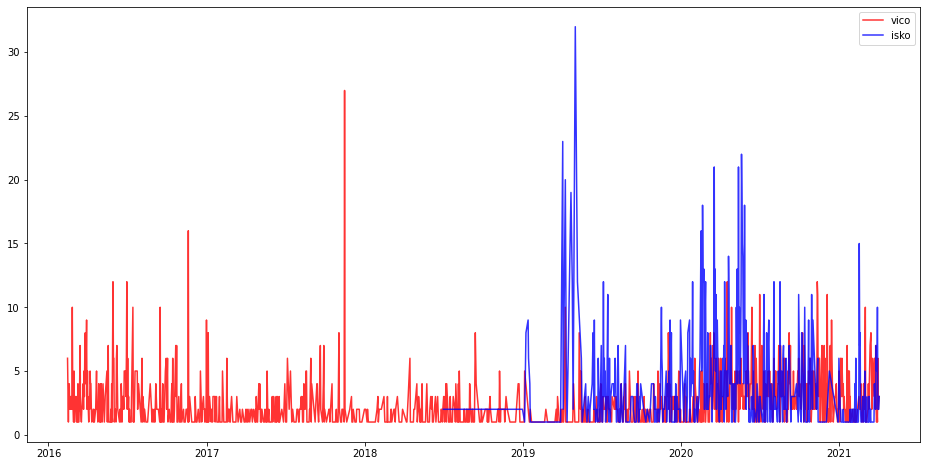

In [13]:
# Distribution of tweets by Vico Sotto
vico_tweet_counts = vico_tweets['created_at']
vico_tweet_counts.index = pd.to_datetime(vico_tweet_counts.apply(lambda x: x.split()[0]))
vico_tweet_counts = vico_tweet_counts.groupby(by=vico_tweet_counts.index).count()

# Distribution of tweets by Isko Moreno
isko_tweet_counts = isko_tweets['created_at']
isko_tweet_counts.index = pd.to_datetime(isko_tweet_counts.apply(lambda x: x.split()[0]))
isko_tweet_counts = isko_tweet_counts.groupby(by=isko_tweet_counts.index).count()

fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(vico_tweet_counts.index.to_pydatetime(), vico_tweet_counts.values, c='r', label='vico', alpha=0.8)
plt.plot(isko_tweet_counts.index.to_pydatetime(), isko_tweet_counts.values, c='b', label='isko', alpha=0.8)
plt.legend()
plt.plot()

This tells us that Vico Sotto has been active on twitter for over two years longer than Isko Moreno.


**Which days had the most tweets?**

**Vico Sotto**

In [14]:
print(vico_tweet_counts[np.argmax(vico_tweet_counts)])
print(vico_tweet_counts.index[np.argmax(vico_tweet_counts)])

27
2017-11-15 00:00:00


**Vico made 27 tweets on November 15, 2017.**

In [15]:
vico_tweets[(vico_tweets['created_at'].index.year == 2017) & (vico_tweets['created_at'].index.month == 11) & (vico_tweets['created_at'].index.day==15)]

,id,created_at,favorite_count,retweet_count,text,target
1999,930816026660368384,2017-11-15 15:13:29,5,0,@JasmineAlmira ⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪🔵❤️⚪⚪\n⚪⚪⚪...,vico
2000,930813337666859008,2017-11-15 15:02:48,26,0,NO CHEATING NAMAN https://t.co/jpnDlC2unK,vico
2001,930813128740298752,2017-11-15 15:01:58,2,0,@JasmineAlmira ⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪🔵⚪⚪⚪\n⚪⚪⚪🔴...,vico
2002,930808788277280769,2017-11-15 14:44:43,0,0,@JasmineAlmira ⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪🔴...,vico
2003,930808309044486145,2017-11-15 14:42:49,0,0,@JasmineAlmira ⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪...,vico
2004,930807677705363457,2017-11-15 14:40:18,0,0,@JasmineAlmira ⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪...,vico
2005,930806637958283264,2017-11-15 14:36:10,2,1,@iMarkTiczon 🔵⚪⚪🔴⚪⚪⚪&lt;\n🔴⚪🔴🔴🔴⚪⚪&lt;\n🔵🔴🔵🔴🔵⚪⚪...,vico
2006,930805765681463297,2017-11-15 14:32:42,0,0,@JasmineAlmira ⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪...,vico
2007,930805553709723648,2017-11-15 14:31:52,0,0,@iMarkTiczon 🔵⚪⚪🔴⚪⚪⚪\n🔴⚪🔴🔴🔴⚪⚪\n🔵⚪🔵🔴🔵⚪⚪\n🔴🔴🔵🔵🔵⚪...,vico
2008,930804399303114752,2017-11-15 14:27:16,0,0,@JasmineAlmira ⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪⚪⚪⚪\n⚪⚪⚪⚪...,vico


In [16]:
print(vico_tweets.iloc[2001]['text'])

@JasmineAlmira ⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪🔵⚪⚪⚪
⚪⚪⚪🔴🔴⚪⚪
⚪⚪🔴🔴🔵⚪⚪
⚪🔴🔵🔵🔴🔵⚪
⚪🔵🔴🔴🔴🔵🔵 https://t.co/GpBvfFee4P


**This was because he was playing Connect Four with @JasmineAlmira and @iMarkTiczon.**

**Isko Moreno**

In [17]:
print(isko_tweet_counts[np.argmax(isko_tweet_counts)])
print(isko_tweet_counts.index[np.argmax(isko_tweet_counts)])

32
2019-05-02 00:00:00


**Isko Moreno made 32 tweets on 2019, May 05.**

In [18]:
isko_tweets[(isko_tweets['created_at'].index.year == 2019) & (isko_tweets['created_at'].index.month == 5) & (isko_tweets['created_at'].index.day==2)].head()

,id,created_at,favorite_count,retweet_count,text,target
1718,1123890368309809152,2019-05-02 10:01:59,11,3,IN THE NEWS: Isko Moreno ibabalik ang metro ai...,isko
1719,1123890204052545536,2019-05-02 10:01:20,20,3,Bagong Maynila!\n\nIyan ang nais ng mga Batang...,isko
1720,1123852151325904896,2019-05-02 07:30:07,4,2,IN THE NEWS: For actor-turned-politician Franc...,isko
1721,1123851947054968832,2019-05-02 07:29:18,3,1,IN THE NEWS: Isko Moreno ibabalik ang metro ai...,isko
1722,1123851853467398144,2019-05-02 07:28:56,6,1,IN THE NEWS: ‘Real Manileño’ ready to reclaim ...,isko


In [19]:
print(isko_tweets.iloc[1716]['text'])
print("_"*50)

Walang ibang hangad ang Batang Maynila Isko Moreno Domagoso kasama ang buong Team Asenso Manileño kundi ang ikabubuti at ikauunlad ng pamumuhay ng bawat mamamayan ng Maynila kaya't patuloy pa rin ang pagbuhos ng suporta ng Distrito 5 at 6.

#BatangMaynila
#AsensoManileno https://t.co/FBrr5rgLrt
__________________________________________________


**This was due to him retweeting news articles about his campaign promises.**

### Preprocessing

We will use the `text` column as the feature, and the `target` column as the target.

In [20]:
df_reduced = df[['text', 'target']]

For preprocessing, we set the text to lowercase, remove stopwords, and tokenize.

In [21]:
# Filipino stopwords from: https://github.com/stopwords-iso/stopwords-tl
with open("data/tl-stopwords.txt") as f:
    tl_stop = [s.strip() for s in f.readlines()]
en_stop = stopwords.words("english")
en_tl_stop = tl_stop + en_stop

In [22]:
def preprocess(text):
    text=text.lower()
    text=re.sub('[^0-9a-z]+',' ',text)
    split = text.split()
    stopped = [i for i in split if i not in en_tl_stop]
    return(stopped)

In [23]:
df_reduced['text'] = df_reduced['text'].apply(preprocess)

In [24]:
df_reduced

,text,target
0,"[risen, ngayong, araw, ika, 4, abril, pong, gu...",isko
1,"[po, vaccination, sites, natin, bukas, april, ...",isko
2,"[covid, 19, monitoring, latest, coronavirus, d...",isko
3,"[sama, sama, po, nating, gunitain, ngayong, ar...",isko
4,"[covid, 19, monitoring, latest, coronavirus, d...",isko
...,...,...
4846,"[mcrosalie, 716, hmm, babae, si, ate, mons, haha]",vico
4847,"[marieten09, first]",vico
4848,"[24cheanne, hi, lang]",vico
4849,"[msaflowering, happy, valentine, day]",vico


Since we only have two targets, we convert the `target` column to binary.
- 0 = vico
- 1 = isko

In [25]:
df_reduced['target'] = df_reduced['target'].apply(lambda x: 0 if x=="vico" else 1)

In [26]:
df_reduced

,text,target
0,"[risen, ngayong, araw, ika, 4, abril, pong, gu...",1
1,"[po, vaccination, sites, natin, bukas, april, ...",1
2,"[covid, 19, monitoring, latest, coronavirus, d...",1
3,"[sama, sama, po, nating, gunitain, ngayong, ar...",1
4,"[covid, 19, monitoring, latest, coronavirus, d...",1
...,...,...
4846,"[mcrosalie, 716, hmm, babae, si, ate, mons, haha]",0
4847,"[marieten09, first]",0
4848,"[24cheanne, hi, lang]",0
4849,"[msaflowering, happy, valentine, day]",0


### Generate word embeddings with Word2Vec

We will the use the average word embedding for each tweet as our feature.

In [27]:
model = Word2Vec(vector_size=100,window=5,min_count=30, sg=0, alpha = 0.025)
model.build_vocab(df_reduced['text'])

In [28]:
model.train(df_reduced['text'], total_examples=model.corpus_count, epochs=20)

(497875, 1709760)

In [29]:
model.wv.index_to_key[:10]

['co',
 'https',
 'po',
 'manila',
 'city',
 'natin',
 'pasig',
 'lang',
 'maynila',
 'covid']

In [30]:
model.wv.most_similar('covid')

[('19', 0.8343752026557922),
 ('update', 0.7927007675170898),
 ('monitoring', 0.7802563905715942),
 ('swab', 0.7533193826675415),
 ('mass', 0.7338048815727234),
 ('center', 0.7173777222633362),
 ('testing', 0.7141691446304321),
 ('latest', 0.7094623446464539),
 ('cases', 0.7046419978141785),
 ('response', 0.6971128582954407)]

### Get average word embedding

In [31]:
def get_avg_vec(word_list, model):
    words = [word for word in word_list if word in model.wv]
    if len(words) > 0:
        res = np.mean(model.wv[words], axis=0)
    else:
        res = np.zeros(model.vector_size)
    return res    

In [32]:
df_reduced['avg_vec'] = df_reduced['text'].apply(get_avg_vec, model=model)

In [33]:
df_reduced.head()

,text,target,avg_vec
0,"[risen, ngayong, araw, ika, 4, abril, pong, gu...",1,"[-0.5534315, 0.054501303, -0.051558938, 0.3771..."
1,"[po, vaccination, sites, natin, bukas, april, ...",1,"[-0.30520192, 0.09016193, 0.1442648, 0.3332809..."
2,"[covid, 19, monitoring, latest, coronavirus, d...",1,"[-0.13118148, 0.2210957, 0.46720263, 0.4505083..."
3,"[sama, sama, po, nating, gunitain, ngayong, ar...",1,"[-0.62748444, -0.03803376, -0.083121836, 0.350..."
4,"[covid, 19, monitoring, latest, coronavirus, d...",1,"[-0.13118148, 0.2210957, 0.46720263, 0.4505083..."


We can remove the `text` column now.

In [34]:
df_reduced = df_reduced[['avg_vec', 'target']]

### Split into Train and Test Sets

In [35]:
train_set, test_set = train_test_split(df_reduced, train_size=0.8, random_state=SEED)
X_train, y_train = train_set['avg_vec'].values, train_set['target'].values
X_test, y_test = test_set['avg_vec'].values, test_set['target'].values

In [36]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3880,)
(3880,)
(971,)
(971,)


Convert from 1d array of arrays to 2d matrix:

In [37]:
X_train = np.concatenate(X_train, axis=0).reshape(-1, 100)
X_test = np.concatenate(X_test, axis=0).reshape(-1, 100)

print(X_train.shape)
print(X_test.shape)

(3880, 100)
(971, 100)


# Model Training and Evaluation

**We will use `LogisticRegression` and the `predict_proba` method to find the highest and lowest probability tweets by each person (in the test set).**

In [38]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [39]:
pred = logreg.predict(X_test)
pd.Series(pred).value_counts()

0    607
1    364
dtype: int64

In [40]:
sum(pred == np.array(y_test)) / len(y_test)

0.8692070030895983

**The model can classify tweets with an accuracy of $\approx 87\%$. (correct predictions / total predictions)**

In [41]:
logreg.classes_

array([0, 1])

Note that: 0=vico, 1=isko

In [42]:
pred = logreg.predict_proba(X_test)
vico_probas = pd.Series(pred[:, 0])
isko_probas = pd.Series(pred[:, 1])

In [43]:
# Probability that tweets made by Isko were made by Isko
isko_ground_truth_probas = isko_probas[y_test.astype(np.bool)]

# Probability that tweets made by Vico were made by Vico
vico_ground_truth_probas = vico_probas[~y_test.astype(np.bool)]

### Highest Probability Isko Moreno tweet

In [44]:
print(df.iloc[test_set.index[isko_ground_truth_probas.idxmax()]]['text'])

Tara na mga Batang Maynila tungo sa Bagong Maynila!

#BatangMaynila #AsensoManileno 🇵🇭


In [45]:
print(f"Probability: {isko_ground_truth_probas.max()}")

Probability: 0.9999921816907669


In [46]:
%%html
<blockquote class="twitter-tweet"><p lang="tl" dir="ltr">Tara na mga Batang Maynila tungo sa Bagong Maynila!<a href="https://twitter.com/hashtag/BatangMaynila?src=hash&amp;ref_src=twsrc%5Etfw">#BatangMaynila</a> <a href="https://twitter.com/hashtag/AsensoManileno?src=hash&amp;ref_src=twsrc%5Etfw">#AsensoManileno</a> 🇵🇭</p>&mdash; Isko Moreno Domagoso (@IskoMoreno) <a href="https://twitter.com/IskoMoreno/status/1113296666788945922?ref_src=twsrc%5Etfw">April 3, 2019</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

### Lowest Probability Isko Moreno Tweet

In [47]:
print(df.iloc[test_set.index[isko_ground_truth_probas.idxmin()]]['text'])

Para maipakita naming mga taong gobyerno na seryoso kami sa bakuna, ituturok muna namin sa sarili namin ang bakuna, mapanatag lang ang inyong kalooban kapag nakita niyong itinurok na.

Ang pangamba ng tao ay kinokompronta ng mga lider, dahil ang lider ay sinusunod ng tao.


In [48]:
print(f"Probability: {isko_ground_truth_probas.min()}")

Probability: 0.001987165069589502


In [49]:
%%html
<blockquote class="twitter-tweet"><p lang="tl" dir="ltr">Para maipakita naming mga taong gobyerno na seryoso kami sa bakuna, ituturok muna namin sa sarili namin ang bakuna, mapanatag lang ang inyong kalooban kapag nakita niyong itinurok na.<br><br>Ang pangamba ng tao ay kinokompronta ng mga lider, dahil ang lider ay sinusunod ng tao.</p>&mdash; Isko Moreno Domagoso (@IskoMoreno) <a href="https://twitter.com/IskoMoreno/status/1357287305577340928?ref_src=twsrc%5Etfw">February 4, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

### Highest Probability Vico Sotto tweet:

In [50]:
df.iloc[test_set.index[vico_ground_truth_probas.idxmax()]]['text']

'@iamsect Bakit sila defensive? Yung tanong, tungkol SA AKIN at yung sagot ko TUNGKOL DIN SA AKIN.'

In [51]:
print(f"Probability: {vico_ground_truth_probas.max()}")

Probability: 0.9998517154780365


In [52]:
%%html
<blockquote class="twitter-tweet"><p lang="tl" dir="ltr">Bakit sila defensive? Yung tanong, tungkol SA AKIN at yung sagot ko TUNGKOL DIN SA AKIN.</p>&mdash; Vico Sotto (@VicoSotto) <a href="https://twitter.com/VicoSotto/status/1271241358930374656?ref_src=twsrc%5Etfw">June 12, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

### Lowest Probability Vico Sotto tweet:

In [53]:
df.iloc[test_set.index[vico_ground_truth_probas.idxmin()]]['text']

'@marieten09 First'

In [54]:
print(f"Probability: {vico_ground_truth_probas.min()}")

Probability: 0.0013427086456374582


In [55]:
%%html
<blockquote class="twitter-tweet"><p lang="en" dir="ltr"><a href="https://twitter.com/marieten09?ref_src=twsrc%5Etfw">@marieten09</a> First</p>&mdash; Vico Sotto (@VicoSotto) <a href="https://twitter.com/VicoSotto/status/698851507060346880?ref_src=twsrc%5Etfw">February 14, 2016</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>